In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split

from ast import literal_eval

import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [25]:
arxiv_data = pd.read_csv("arxiv_data_210930-054931.csv")

In [26]:
arxiv_data

,terms,titles,abstracts
0,['cs.LG'],Multi-Level Attention Pooling for Graph Neural...,Graph neural networks (GNNs) have been widely ...
1,"['cs.LG', 'cs.AI']",Decision Forests vs. Deep Networks: Conceptual...,Deep networks and decision forests (such as ra...
2,"['cs.LG', 'cs.CR', 'stat.ML']",Power up! Robust Graph Convolutional Network v...,Graph convolutional networks (GCNs) are powerf...
3,"['cs.LG', 'cs.CR']",Releasing Graph Neural Networks with Different...,With the increasing popularity of Graph Neural...
4,['cs.LG'],Recurrence-Aware Long-Term Cognitive Network f...,Machine learning solutions for pattern classif...
...,...,...,...
56176,"['cs.CV', 'cs.IR']",Mining Spatio-temporal Data on Industrializati...,Despite the growing availability of big data i...
56177,"['cs.LG', 'cs.AI', 'cs.CL', 'I.2.6; I.2.7']",Wav2Letter: an End-to-End ConvNet-based Speech...,This paper presents a simple end-to-end model ...
56178,['cs.LG'],Deep Reinforcement Learning with Double Q-lear...,The popular Q-learning algorithm is known to o...
56179,"['stat.ML', 'cs.LG', 'math.OC']",Generalized Low Rank Models,Principal components analysis (PCA) is a well-...


In [27]:
arxiv_data.shape

(56181, 3)

In [28]:
arxiv_data.isnull().sum()

terms        0
titles       0
abstracts    0
dtype: int64

In [29]:
arxiv_data.duplicated().sum()

15054

In [30]:
# getting unique labels
labels_column = arxiv_data['terms'].apply(literal_eval)
labels = labels_column.explode().unique()
print("labels :",labels)
print("lenght :",len(labels))

labels : ['cs.LG' 'cs.AI' 'cs.CR' ... 'D.1.3; G.4; I.2.8; I.2.11; I.5.3; J.3'
 '68T07, 68T45, 68T10, 68T50, 68U35' 'I.2.0; G.3']
lenght : 1177


In [31]:
# remove duplicate entries based on the "titles" (terms) column
# This filters the DataFrame, keeping only the rows where the titles are not duplicated.
arxiv_data = arxiv_data[~arxiv_data['titles'].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")
# There are some terms with occurrence as low as 1.
print(sum(arxiv_data['terms'].value_counts()==1))
# how many unique terms
print(arxiv_data['terms'].nunique())

There are 41105 rows in the deduplicated dataset.
2503
3401


In [32]:
# Filtering the rare terms. (it keeps only those rows where the "terms" value occurs more than once in the original DataFrame.)
arxiv_data_filtered = arxiv_data.groupby('terms').filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(38602, 3)

In [33]:
# It evaluates the given string containing a Python literal or container display (e.g., a list or dictionary) and returns the corresponding Python object.
arxiv_data_filtered['terms'] = arxiv_data_filtered['terms'].apply(lambda x: literal_eval(x))
arxiv_data_filtered['terms'].values[:3]

array([list(['cs.LG']), list(['cs.LG', 'cs.AI']),
       list(['cs.LG', 'cs.CR', 'stat.ML'])], dtype=object)

In [34]:
test_split = 0.1

# Initial train and test split.
# The stratify parameter ensures that the splitting is done in a way that preserves the same distribution of labels (terms) in both the training and test sets.
train_df, test_df = train_test_split(arxiv_data_filtered,test_size=test_split,stratify=arxiv_data_filtered["terms"].values,)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 34741
Number of rows in validation set: 1930
Number of rows in test set: 1931


In [35]:
# creates a TensorFlow RaggedTensor (terms) from the values in the "terms" column of the train_df DataFrame. A RaggedTensor is a tensor with non-uniform shapes
terms = tf.ragged.constant(train_df['terms'].values)
# This line creates a StringLookup layer in TensorFlow. The purpose of this layer is to map strings to integer indices and vice versa. The output_mode="multi_hot" indicates that the layer will output a multi-hot encoded representation of the input strings.
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
# This step adapts the StringLookup layer to the unique values in the "terms" column, building the vocabulary.
lookup.adapt(terms)
# retrieve vocabulary
vocab = lookup.get_vocabulary()

print("Vocabulary:\n")
print(vocab)



Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.GR', 'cs.CR', 'math.OC', 'eess.SP', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'eess.SY', 'cs.MA', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'stat.AP', 'cs.CY', 'stat.ME', 'stat.TH', 'math.ST', 'eess.AS', 'cs.SD', 'cs.DS', 'q-bio.QM', 'q-bio.NC', 'stat.CO', 'cs.CG', 'cs.NI', 'cs.GT', 'math.NA', 'cs.SE', 'I.2.6', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'physics.comp-ph', 'cond-mat.dis-nn', 'q-bio.BM', 'math.PR', 'cs.PL', 'cs.LO', '68T45', 'cs.AR', 'physics.data-an', 'quant-ph', 'I.2.10', 'cs.CE', 'cond-mat.stat-mech', 'q-fin.ST', 'I.4.6', 'math.DS', 'cs.CC', '68T05', 'physics.ao-ph', 'physics.soc-ph', 'physics.med-ph', 'cs.PF', 'econ.EM', 'cs.DM', 'I.4.8', 'q-bio.GN', 'astro-ph.IM', 'physics.flu-dyn', 'math.AT', 'hep-ex', 'cs.FL', 'I.4', '68U10', 'q-fin.TR', 'physics.geo-ph', 'I.5.4', 'I.2', 'cond-mat.mtrl-sci', 'I.4.9', '68T10', 'q-fin.CP', 'physics.optics', 'I.4; I.5', '68T07', 'math.AP', 'I.2.6

In [36]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.LG', 'cs.AI', 'cs.ET']
Label-binarized representation: [[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [37]:
# following lines::
# which is used for automatic adjustment of resource usage by TensorFlow's data loading pipeline.

#max_seqlen: Maximum sequence length. It indicates the maximum length allowed for sequences.
max_seqlen = 150
#batch_size: Batch size. It specifies the number of samples to use in each iteration.
batch_size = 128
#padding_token: A token used for padding sequences.
padding_token = "<pad>"
#auto = tf.data.AUTOTUNE: auto is assigned the value tf.data.AUTOTUNE,
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    # creating sequences of labesls
    labels = tf.ragged.constant(dataframe["terms"].values)
    #This line uses the previously defined lookup layer to convert the ragged tensor of labels into a binarized representation. The resulting label_binarized is a NumPy array.
    label_binarized = lookup(labels).numpy()
    # creating sequences of text.
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["abstracts"].values, label_binarized))
    # shuffling data basis on condition
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

"""
In summary, the make_dataset function is designed to create a 
dataset suitable for training a model. It takes a dataframe as input, 
assumes it has "abstracts" and "terms" columns, and creates a dataset of 
batches where each batch consists of abstract 
sequences and their corresponding binarized label sequences. 
"""

'\nIn summary, the make_dataset function is designed to create a \ndataset suitable for training a model. It takes a dataframe as input, \nassumes it has "abstracts" and "terms" columns, and creates a dataset of \nbatches where each batch consists of abstract \nsequences and their corresponding binarized label sequences. \n'

In [38]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [39]:
def invert_multi_hot(encoded_labels):
    hot_indeces = np.argwhere(encoded_labels==1.0)[...,0]
    return np.take(vocab, hot_indeces)

text_batch,label_batch=next(iter(train_dataset))
for i, text in enumerate(text_batch[:5]):
    label=label_batch[i].numpy()[None, ...]
    print(text)
    print(invert_multi_hot(label))

tf.Tensor(b'We present an autoencoder that leverages learned representations to better\nmeasure similarities in data space. By combining a variational autoencoder with\na generative adversarial network we can use learned feature representations in\nthe GAN discriminator as basis for the VAE reconstruction objective. Thereby,\nwe replace element-wise errors with feature-wise errors to better capture the\ndata distribution while offering invariance towards e.g. translation. We apply\nour method to images of faces and show that it outperforms VAEs with\nelement-wise similarity measures in terms of visual fidelity. Moreover, we show\nthat the method learns an embedding in which high-level abstract visual\nfeatures (e.g. wearing glasses) can be modified using simple arithmetic.', shape=(), dtype=string)
['[UNK]' '[UNK]' '[UNK]']
tf.Tensor(b'A color image contains luminance and chrominance components representing the\nintensity and color information respectively. The objective of the work\np

In [40]:
vocabulary = set()
train_df["abstracts"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

159035


## Vectorization

In [41]:
# Initializes a TextVectorization layer
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size,ngrams=2,output_mode="tf_idf")
# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [42]:
"""
Mapping Vectorization to Datasets: The code maps the text vectorization operation to 
each element of the training, validation, and test datasets. This ensures that the text
data in each dataset is transformed into numerical vectors using the adapted TextVectorization layer.
The num_parallel_calls parameter is used to parallelize the mapping process, and prefetch is 
applied to prefetch data batches 
for better performance.
"""
train_dataset = train_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)


In [44]:
# creating shallow_mlp_model  (MLP)
from tensorflow.keras.callbacks import EarlyStopping

# Creating shallow_mlp_model (MLP) with dropout layers
model1 = keras.Sequential([
    # First hidden layer: 512 neurons, ReLU activation function, with dropout.
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Second hidden layer: 256 neurons, ReLU activation function, with dropout.
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Output layer: The number of neurons equals the vocabulary size (output vocabulary of the StringLookup layer), with a sigmoid activation function.
    layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
])

# Compile the model
model1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['binary_accuracy'])

# Add early stopping
# Number of epochs with no improvement after which training will be stopped.
# Restore weights from the epoch with the best value of the monitored quantity.
early_stopping = EarlyStopping(patience=5,restore_best_weights=True)

# Train the model
# Add early stopping callback.verbose=1
history = model1.fit(train_dataset,validation_data=validation_dataset,epochs=20,callbacks=[early_stopping])

Epoch 1/20
272/272 [==============================] - 198s 719ms/step - loss: 0.0481 - binary_accuracy: 0.9835 - val_loss: 0.0189 - val_binary_accuracy: 0.9945
Epoch 2/20
272/272 [==============================] - 3063s 11s/step - loss: 0.0174 - binary_accuracy: 0.9950 - val_loss: 0.0183 - val_binary_accuracy: 0.9946
Epoch 3/20
272/272 [==============================] - 196s 721ms/step - loss: 0.0137 - binary_accuracy: 0.9958 - val_loss: 0.0194 - val_binary_accuracy: 0.9945
Epoch 4/20
272/272 [==============================] - 196s 720ms/step - loss: 0.0113 - binary_accuracy: 0.9965 - val_loss: 0.0190 - val_binary_accuracy: 0.9945
Epoch 5/20
272/272 [==============================] - 196s 720ms/step - loss: 0.0098 - binary_accuracy: 0.9970 - val_loss: 0.0200 - val_binary_accuracy: 0.9945
Epoch 6/20
272/272 [==============================] - 196s 721ms/step - loss: 0.0086 - binary_accuracy: 0.9974 - val_loss: 0.0203 - val_binary_accuracy: 0.9946
Epoch 7/20
272/272 [=====================

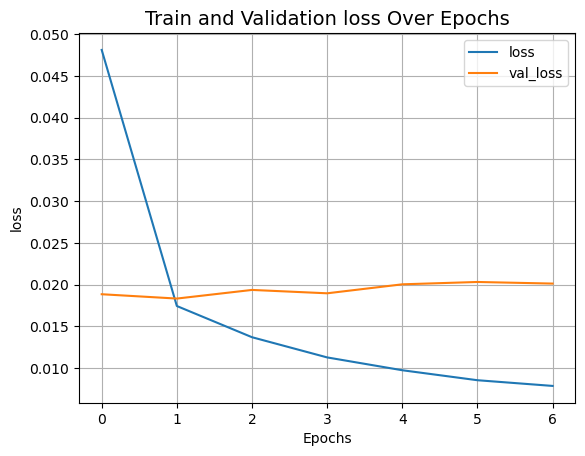

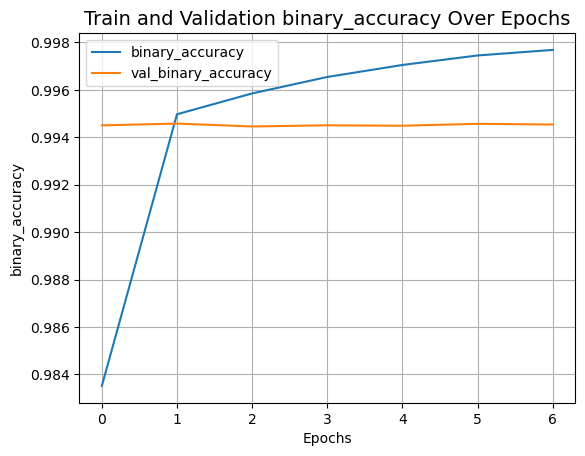

In [45]:
# plotting loss
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [46]:
# model evaltuation on test and val dataset
_, binary_acc1 = model1.evaluate(test_dataset)
_, binary_acc2 = model1.evaluate(validation_dataset)

print(f"Categorical accuracy on the test set: {round(binary_acc1 * 100, 2)}%.")
print(f"Categorical accuracy on the validation set: {round(binary_acc2 * 100, 2)}%.")

16/16 [==============================] - 2s 124ms/step - loss: 0.0183 - binary_accuracy: 0.9946
Categorical accuracy on the test set: 99.49%.
Categorical accuracy on the validation set: 99.46%.


In [48]:
import pickle
# Save the model
model1.save("models/model.h5")

# Save the configuration of the text vectorizer
saved_text_vectorizer_config = text_vectorizer.get_config()
with open("models/text_vectorizer_config.pkl", "wb") as f:
    pickle.dump(saved_text_vectorizer_config, f)


saved_text_weights=text_vectorizer.get_weights()
with open("models/text_vectorizer_weights.pkl","wb") as f:
    pickle.dump(saved_text_weights,f)


# Save the vocabulary
with open("models/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

In [49]:
from tensorflow import keras
import pickle

# Load the model
loaded_model = keras.models.load_model("models/model.h5")

from tensorflow.keras.layers import TextVectorization

# Load the configuration of the text vectorizer
with open("models/text_vectorizer_config.pkl", "rb") as f:
    saved_text_vectorizer_config = pickle.load(f)

# Create a new TextVectorization layer with the saved configuration
loaded_text_vectorizer = TextVectorization.from_config(saved_text_vectorizer_config)

# Load the saved weights into the new TextVectorization layer
with open("models/text_vectorizer_weights.pkl", "rb") as f:
    weights = pickle.load(f)
    loaded_text_vectorizer.set_weights(weights)

## Recomendatiion system

In [4]:
arxiv_data.drop(columns = ["terms","abstracts"], inplace = True)

## Sentence transform

In [5]:
!pip install -U -q sentence-transformers

In [6]:
from sentence_transformers import SentenceTransformer, util

In [7]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [8]:
sentences = arxiv_data['titles']


In [9]:

embeddings = model.encode(sentences)

In [10]:
embeddings.shape

(56181, 384)

## printing embeddings

In [11]:
c = 0

for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding length:", len(embedding))
    print("")
    
    if c >=5:
        break
    c +=1 

Sentence: Multi-Level Attention Pooling for Graph Neural Networks: Unifying Graph Representations with Multiple Localities
Embedding length: 384

Sentence: Decision Forests vs. Deep Networks: Conceptual Similarities and Empirical Differences at Small Sample Sizes
Embedding length: 384

Sentence: Power up! Robust Graph Convolutional Network via Graph Powering
Embedding length: 384

Sentence: Releasing Graph Neural Networks with Differential Privacy Guarantees
Embedding length: 384

Sentence: Recurrence-Aware Long-Term Cognitive Network for Explainable Pattern Classification
Embedding length: 384

Sentence: Lifelong Graph Learning
Embedding length: 384



## SAve file

In [12]:
import pickle
# Saving sentences and corresponding embeddings
with open('models/embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

with open('models/sentences.pkl', 'wb') as f:
    pickle.dump(sentences, f)
    
with open('models/rec_model.pkl', 'wb') as f:
    pickle.dump(model, f)

## load files

In [13]:
# load save files
embeddings = pickle.load(open('models/embeddings.pkl','rb'))
sentences = pickle.load(open('models/sentences.pkl','rb'))
rec_model = pickle.load(open('models/rec_model.pkl','rb'))

In [14]:
import torch

def recommendation(input_paper):
    # Calculate cosine similarity scores between the embeddings of input_paper and all papers in the dataset.
    cosine_scores = util.cos_sim(embeddings, rec_model.encode(input_paper))
    
    # Get the indices of the top-k most similar papers based on cosine similarity.
    top_similar_papers = torch.topk(cosine_scores, dim=0, k=5, sorted=True)
                                 
    # Retrieve the titles of the top similar papers.
    papers_list = []
    for i in top_similar_papers.indices:
        papers_list.append(sentences[i.item()])
    
    return papers_list

In [15]:
input_paper = input("Enter the title of any paper you like")
recommend_papers = recommendation(input_paper)


print("We recommend to read this paper............")
print("=============================================")
for paper in recommend_papers:
    print(paper)

Enter the title of any paper you likeA Review of Deep Learning with Special Emphasis on Architectures, Applications and Recent Trends Review of Deep Learning
We recommend to read this paper............
A Review of Deep Learning with Special Emphasis on Architectures, Applications and Recent Trends
Review of Deep Learning
A Survey of the Recent Architectures of Deep Convolutional Neural Networks
A Survey of the Recent Architectures of Deep Convolutional Neural Networks
A Survey of the Recent Architectures of Deep Convolutional Neural Networks


In [16]:
input_paper = input("Enter the title of any paper you like")
recommend_papers = recommendation(input_paper)


print("We recommend to read this paper............")
print("=============================================")
for paper in recommend_papers:
    print(paper)

Enter the title of any paper you likeA Review of Deep Learning with Special Emphasis on Architectures, Applications and Recent Trends Review of Deep Learning
We recommend to read this paper............
A Review of Deep Learning with Special Emphasis on Architectures, Applications and Recent Trends
Review of Deep Learning
A Survey of the Recent Architectures of Deep Convolutional Neural Networks
A Survey of the Recent Architectures of Deep Convolutional Neural Networks
A Survey of the Recent Architectures of Deep Convolutional Neural Networks


In [17]:
# install this versions
import sentence_transformers
import tensorflow
import torch
print(torch.__version__)
print(sentence_transformers.__version__)
print(tensorflow.__version__)

2.1.0+cpu
2.6.1
2.15.0


In [18]:
! pip install tensorflow==2.15.0


In [19]:
! pip install sentence-transformers==2.2.2


  Using cached sentence_transformers-2.2.2-py3-none-any.whl
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.6.1
    Uninstalling sentence-transformers-2.6.1:
      Successfully uninstalled sentence-transformers-2.6.1


In [20]:
# install this versions
import sentence_transformers
import tensorflow
import torch
print(torch.__version__)
print(sentence_transformers.__version__)
print(tensorflow.__version__)

2.1.0+cpu
2.6.1
2.15.0
